## Demystifying spectral clustering with graph cuts for unsupervised image segmentation

### References: 

[1] https://people.eecs.berkeley.edu/~malik/papers/SM-ncut.pdf

[2] http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.165.9323&rep=rep1&type=pdf

In [31]:
import numpy as np 
import matplotlib as plt
from scipy import misc
from skimage.transform import resize
import matplotlib.pyplot as plt 
from numpy import linalg as LA
from scipy.sparse import csgraph
import networkx as nx
from sklearn.feature_extraction.image import img_to_graph
from sklearn.cluster import spectral_clustering
print('DONE')

DONE


## Helper functions

In [0]:
def find_eig_critical(eigVal):
  """
  finds minimum non-zero eigenvalue
  """
  min_val = 2.1
  for count,i in enumerate(eigVal):
    if ( i<min_val and i>0.0001):
      min_val = i
      pos = count
  return min_val,pos 

def im2graph(img):
  """
  Custom greyscale image to graph.
  Does not work very well! 
  """
  lx,ly = img.shape
  size  = lx*ly
  W = np.zeros( (size,size) )
  r = 10
  s_i = 1
  s_s = 6
  counter = 0
  for i1 in range(lx):
    for j1 in range(ly):
      list = []
      for i2 in range(lx):
        for j2 in range(ly):
          if ( (abs(i1-i2)+abs(j1-j2))< r  ): #1st norm
            intens = LA.norm( [ img[i1,j1],img[i2,j2] ] , 2 )
            spat =  LA.norm( [  (i1-i2), (j1-j2) ] , 2)
            intens = np.exp(-1*intens/s_i)
            spat = np.exp(-1*spat/s_s)
            w = intens*spat
          else:
            w=0
          list.append(w)
      W[counter,:] = list
      counter += 1
      
  return W

def segment_image(img, eigvec):
  """
  Binary image segmentation based on the values of  the critical eigenvector.
  The latter is the one that corresponds to the minimum non-zero eigenvalue.
  Intuitively, it is the lowest frequency of the image!
  """
  lx,ly = img.shape
  mask = np.ones( eigvec.shape)
  for c,i in enumerate(eigvec):
    prev = eigvec[c]
    if (i>0.0001):
      mask[c] = 0
  
  mask2 = np.reshape( mask , (lx,ly) )
  new_img = np.multiply( img ,mask2  ) # element wise mulitplication
  return new_img

# Main Code

## 1. Load and rescale Image

In [0]:
#Parameters
re_size = 64 # downsampling of resized rectangular image 

f = misc.face(gray=True)  # retrieve a grayscale image
f = resize(f, (re_size, re_size))

## 2. Convert Image to Adjecency Matrix (weighted graph)

Convert the image into a graph with the value of the gradient on the edges.
graph = image.img_to_graph(img)

Take a decreasing function of the gradient: we take it weakly dependant from the gradient the segmentation is close to a voronoi

In [0]:
W1 = img_to_graph(f, return_as=np.ndarray) # gradient weighted
W1 = np.exp(-W1 / W1.std())


W2 = im2graph(f) # spatial location and intensity-based weighted

## 3. Calculate Laplacian

In [0]:
## 1. Using csgraph
Lapl_1 =  csgraph.laplacian(W1, normed=True) 
print(Lapl_1.shape)

## 2. Using networkx
G = nx.from_numpy_matrix(W1)
Lapl_2 = nx.normalized_laplacian_matrix(G)
Lapl_2b = nx.laplacian_matrix(G)
print(Lapl_2.shape)


## 3. Doing the math --> https://en.wikipedia.org/wiki/Laplacian_matrix
D = (np.diag(np.power(W1.sum(axis=1), -0.5)))
k = re_size*re_size
Lapl_3 = np.ones(k) - np.matmul(np.matmul(D, W1), D) 
Lapl_4 = D - W1
print(Lapl_3.shape)



print(np.sum(Lapl_1-Lapl_2)) # both works great!
print(np.sum(Lapl_1-Lapl_3))
print(np.sum(Lapl_1-Lapl_3))
print(np.sum(Lapl_2-Lapl_3))

(4096, 4096)


## 4. Eigenanalysis on normalized Laplacian

We perform singular value decomposition(SVD) https://en.wikipedia.org/wiki/Singular_value_decomposition to find the eigenvalues and eigenvectors. The eigenvalues are the frequencies tha exist in the image.

In [0]:
eigVal , eigVec = LA.eig(Lapl_1) 

## 5. Keep minimum non-zero eigenVector of normalized Laplacian

The critical eigenvalue is the one with the minimum non-zero value.
The corresponding eigenvector values(>0 or <0), will be the binary desicion to segment the image.
The number of zero eigenvalues corresponds to the number of connected components in the graph!


In [40]:
min_eig , pos = find_eig_critical(eigVal)  
print(min_eig, pos)

eig_vec_critical = eigVec[:,pos] 

0.9993081285572201 3


## 6. Segment Image based on critical eigenvector

In [0]:
new_img = segment_image(f, eig_vec_critical)


## 7. Test & Plot Results!

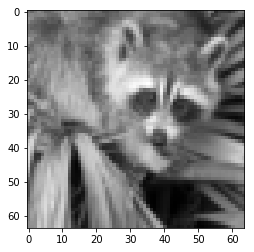

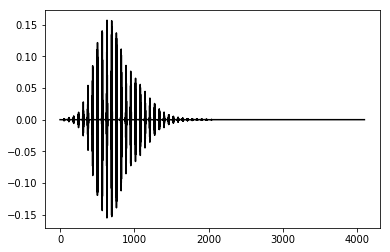

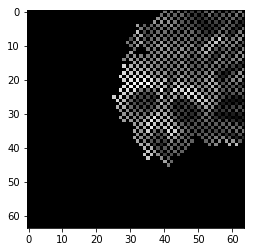

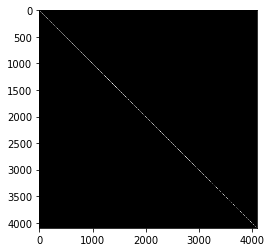

In [58]:
fig = plt.figure()
plt.imshow(f,cmap=plt.cm.gray)
#fig.set_title('Rescaled Img')

fig2 = plt.figure()
plt.plot(eig_vec_critical, 'k-')
#fig2.set_title('Minimum non zero eigVec')

fig3 = plt.figure()
plt.imshow( new_img,cmap=plt.cm.gray,interpolation='nearest'  )
#fig3.set_title('Segmentation')

fig4 = plt.figure()
plt.imshow(W,cmap=plt.cm.gray)
#fig4.set_title('Adjecency Matrix')

plt.show()



## 8. Comparison with built-in python function/tutorial

Tutorial code taken from https://scipy-lectures.org/advanced/image_processing/auto_examples/plot_spectral_clustering.html

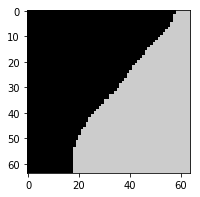

In [62]:
#Parameters
re_size = 64 # downsampling of resized rectangular image 
img = misc.face(gray=True)  # retrieve a grayscale image
img = resize(img, (re_size, re_size))
mask = img.astype(bool)
graph = img_to_graph(img, mask=mask)
# Take a decreasing function of the gradient: we take it weakly
# dependant from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())
labels = spectral_clustering(graph, n_clusters=2)
label_im = -np.ones(mask.shape)
label_im[mask] = labels

plt.figure(figsize=(6, 3))
plt.imshow(img, cmap=plt.cm.nipy_spectral, interpolation='nearest')
plt.imshow(label_im, cmap=plt.cm.nipy_spectral, interpolation='nearest')
plt.show()

In [10]:
x = np.arange(9)*3
y = np.diag(x)+np.ones(9)
y[0,1]=200
print(y)
print(np.sum(y,axis=1))
print(np.sum(y,axis=0))

[[  1. 200.   1.   1.   1.   1.   1.   1.   1.]
 [  1.   4.   1.   1.   1.   1.   1.   1.   1.]
 [  1.   1.   7.   1.   1.   1.   1.   1.   1.]
 [  1.   1.   1.  10.   1.   1.   1.   1.   1.]
 [  1.   1.   1.   1.  13.   1.   1.   1.   1.]
 [  1.   1.   1.   1.   1.  16.   1.   1.   1.]
 [  1.   1.   1.   1.   1.   1.  19.   1.   1.]
 [  1.   1.   1.   1.   1.   1.   1.  22.   1.]
 [  1.   1.   1.   1.   1.   1.   1.   1.  25.]]
[208.  12.  15.  18.  21.  24.  27.  30.  33.]
[  9. 211.  15.  18.  21.  24.  27.  30.  33.]


In [14]:
temp = W1.sum(axis=1)
temp = np.power(temp, -0.5)
D = (np.diag(temp))
print(D.shape)
print(D[500,500])
print(D[300,200])

(4096, 4096)
1.3693063937629149
0.0
